In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

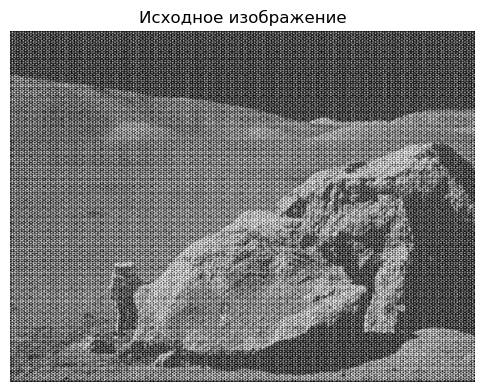

In [2]:
img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

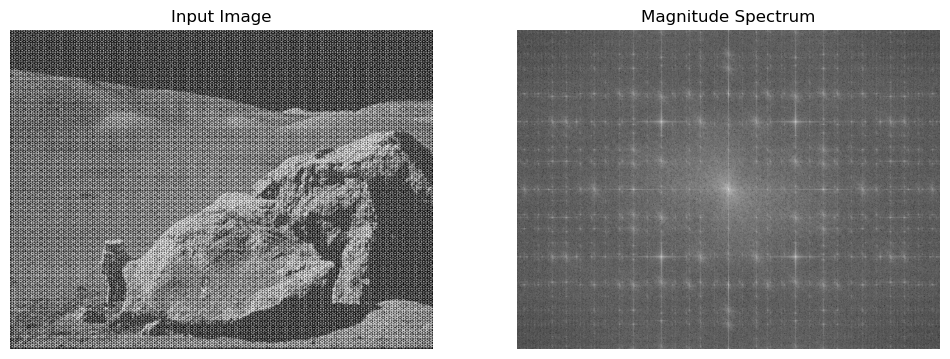

In [3]:
# Прямое преобразование Фурье
dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)

# Сдвиг нулевой частоты в центр спектра
dft_shift = np.fft.fftshift(dft)

# Амплитудный спектр
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:, :, 0],
                                              dft_shift[:, :, 1]) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')
plt.show()


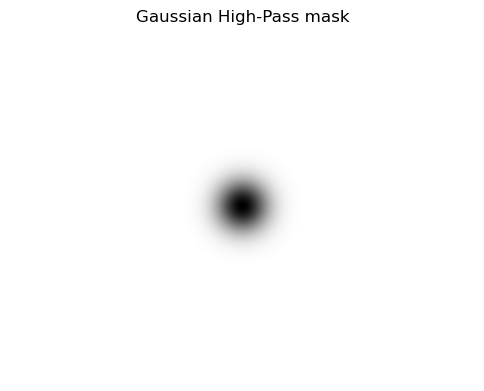

In [4]:
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

sigma = 30

x = np.arange(cols)
y = np.arange(rows)
X, Y = np.meshgrid(x, y)

# Гауссово низкочастотное ядро (LPF)
gaussian_lpf = np.exp(-((X - ccol)**2 + (Y - crow)**2) / (2 * sigma**2))

gaussian_hpf = 1 - gaussian_lpf

plt.figure(figsize=(6,6))
plt.imshow(gaussian_hpf, cmap='gray')
plt.title('Gaussian High-Pass mask')
plt.axis('off')
plt.show()

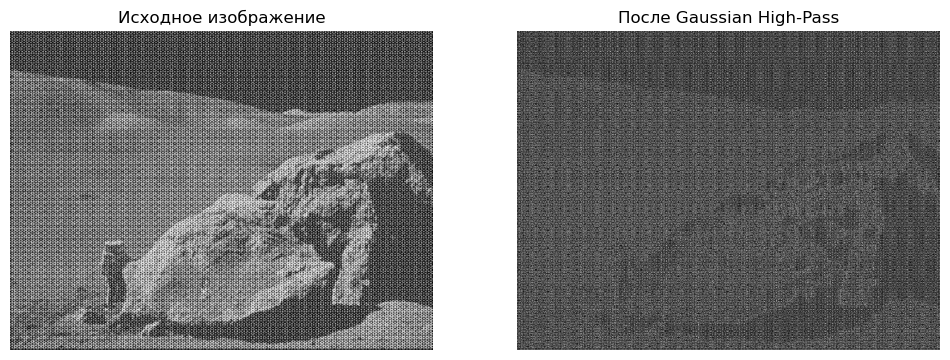

In [5]:
dft_hpf = dft_shift * gaussian_hpf[:, :, np.newaxis]

# Обратный сдвиг и обратное DFT
f_ishift = np.fft.ifftshift(dft_hpf)
img_back_hpf = cv.idft(f_ishift)

# Амплитуда результата
img_back_hpf = cv.magnitude(img_back_hpf[:, :, 0],
                            img_back_hpf[:, :, 1])

img_back_hpf = cv.normalize(img_back_hpf, None, 0, 255, cv.NORM_MINMAX)
img_back_hpf = np.uint8(img_back_hpf)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_back_hpf, cmap='gray')
plt.title('После Gaussian High-Pass')
plt.axis('off')
plt.show()


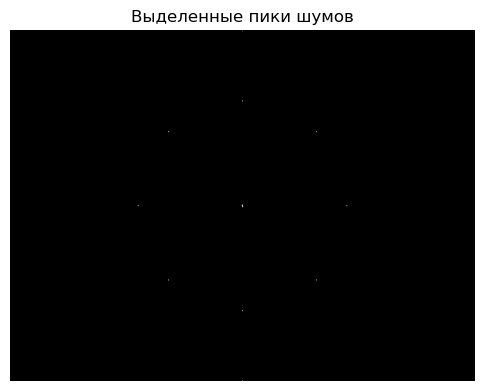

Количество найденных пиков: 25


In [6]:
magnitude_norm = cv.normalize(magnitude_spectrum, None, 0, 255,
                              cv.NORM_MINMAX).astype(np.uint8)

_, thresh = cv.threshold(magnitude_norm, 200, 255, cv.THRESH_BINARY)

plt.figure(figsize=(6,6))
plt.imshow(thresh, cmap='gray')
plt.title('Выделенные пики шумов')
plt.axis('off')
plt.show()

peaks = cv.findNonZero(thresh)
print("Количество найденных пиков:", 0 if peaks is None else len(peaks))

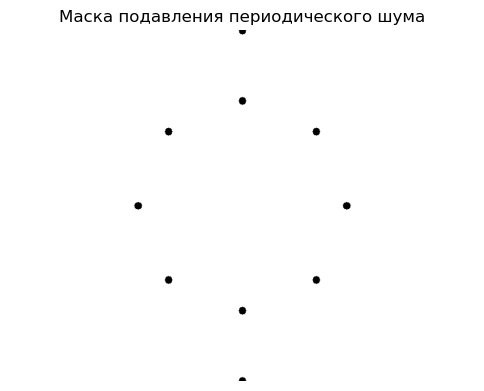

In [7]:
noise_mask = np.ones((rows, cols, 2), np.float32)

r = 6 
if peaks is not None:
    for pt in peaks:
        x, y = pt[0]

        if (x - ccol)**2 + (y - crow)**2 < (2*r)**2:
            continue

        cv.circle(noise_mask, (x, y), r, (0, 0), -1)

plt.figure(figsize=(6,6))
plt.imshow(noise_mask[:, :, 0], cmap='gray')
plt.title('Маска подавления периодического шума')
plt.axis('off')
plt.show()

(np.float64(-0.5), np.float64(786.5), np.float64(593.5), np.float64(-0.5))

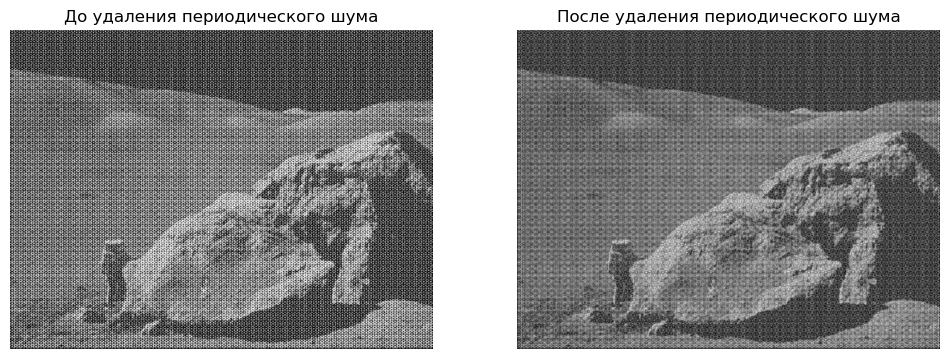

In [8]:
dft_clean = dft_shift * noise_mask

f_ishift_clean = np.fft.ifftshift(dft_clean)
img_back_clean = cv.idft(f_ishift_clean)
img_back_clean = cv.magnitude(img_back_clean[:, :, 0],
                              img_back_clean[:, :, 1])

img_back_clean = cv.normalize(img_back_clean, None, 0, 255, cv.NORM_MINMAX)
img_back_clean = np.uint8(img_back_clean)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('До удаления периодического шума')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_back_clean, cmap='gray')
plt.title('После удаления периодического шума')
plt.axis('off')